# Demo Notebook on how to load the transfer core and train a model

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2 

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import neuralpredictors as neur
import seaborn as sns
from lurz2020.utility.measures import get_correlations, get_fraction_oracles, get_oracles


# Build the dataloaders

The dataloaders object is a dictionary of 3 dictionaries: train, validation and test. Each of them contains the respective data from all datasets combined that were specified in paths. Here we only provide one dataset. While the responses are normalized, we exclude the input images from normalization. The following config was used in the paper (all arguments not in the config have the default value of the function). 

In [3]:
from lurz2020.datasets.mouse_loaders import static_loaders

paths = ['data/static20457-5-9-preproc0']

dataset_config = {'paths': paths, 
                  'batch_size': 64, 
                  'seed': 1, 
                  'cuda': True,
                  'normalize': True, 
                  'exclude': "images"}

dataloaders = static_loaders(**dataset_config)

ImportError: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet


### Look at the data

In [4]:
tier = 'train'
dataset_name = '20457-5-9-0'

images, responses = [], []
for x, y in dataloaders[tier][dataset_name]:
    images.append(x.squeeze().cpu().data.numpy())
    responses.append(y.squeeze().cpu().data.numpy())
    
images = np.vstack(images)
responses = np.vstack(responses)

print('The \"{}\" set of dataset \"{}\" contains the responses of {} neurons to {} images'.format(tier, dataset_name, responses.shape[1], responses.shape[0]))

The "train" set of dataset "20457-5-9-0" contains the responses of 5335 neurons to 4472 images


# Build the model

If you want to load the transfer core later on, the arguments in the model config that concern the architecture of the model can not be changed. The following config was used in the paper (all arguments not in the config have the default value of the function).

In [5]:
from lurz2020.models.models import se2d_fullgaussian2d

model_config = {'init_mu_range': 0.55,
                'init_sigma': 0.4,
                'input_kern': 15,
                'hidden_kern': 13,
                'gamma_input': 1.0,
                'grid_mean_predictor': {'type': 'cortex',
                                        'input_dimensions': 2,
                                        'hidden_layers': 0,
                                        'hidden_features': 0,
                                        'final_tanh': False},
                'gamma_readout': 2.439}

model = se2d_fullgaussian2d(**model_config, dataloaders=dataloaders, seed=1)

# Load Konstantin's model


In [6]:
st_dict = torch.load('models/trained_model.pth.tar') 
model.load_state_dict(st_dict, strict=False)
model = model.cuda().eval()

### Get the performance of your model

In [7]:
get_fraction_oracles?

Signature: get_fraction_oracles(model, dataloaders, device='cpu', corrected=False)
Docstring: <no docstring>
File:      /src/lurz2020/lurz2020/utility/measures.py
Type:      function


In [8]:
train_correlation = get_correlations(model, dataloaders["train"], device='cuda', as_dict=False, per_neuron=False)
validation_correlation = get_correlations(model, dataloaders["validation"], device='cuda', as_dict=False, per_neuron=False)
test_correlation = get_correlations(model, dataloaders["test"], device='cuda', as_dict=False, per_neuron=False)

# Fraction Oracle can only be computed on the test set. It requires the dataloader to give out batches of repeats of images. 
# This is achieved by building a dataloader with the argument "return_test_sampler=True"
oracle_dataloader = static_loaders(**dataset_config, return_test_sampler=True, tier='test')
fraction_oracle = get_fraction_oracles(model=model, dataloaders=oracle_dataloader, device='cuda')[0]

print('-----------------------------------------')
print('Correlation (train set):      {0:.3f}'.format(train_correlation))
print('Correlation (validation set): {0:.3f}'.format(validation_correlation))
print('Correlation (test set):       {0:.3f}'.format(test_correlation))
print('-----------------------------------------')
print('Fraction oracle (test set):   {0:.3f}'.format(fraction_oracle))

Returning only test sampler with repeats...
-----------------------------------------
Correlation (train set):      0.385
Correlation (validation set): 0.326
Correlation (test set):       0.325
-----------------------------------------
Fraction oracle (test set):   0.839


/src/lurz2020/lurz2020/utility/measures.py:239: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  oracle_performance, _, _, _ = np.linalg.lstsq(np.hstack(oracles)[:, np.newaxis], np.hstack(test_correlation))


In [9]:
test_scores = test_correlation = get_correlations(model, dataloaders["test"], device='cuda', as_dict=False, per_neuron=True)

oracles = get_oracles(dataloaders=oracle_dataloader['test'], per_neuron=True)


In [25]:
selecting_neurons = np.where(oracles > np.percentile(oracles, 70), np.ones(oracles.shape), np.zeros(oracles.shape))

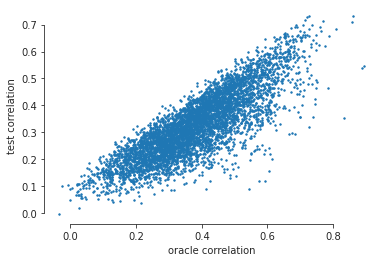

In [27]:
with sns.axes_style('ticks'):
    plt.scatter(oracles, test_scores, s=2)
    sns.despine(trim=True)
    plt.xlabel('oracle correlation')
    plt.ylabel('test correlation')

# Make the model convolutional

In [ ]:
from torch.nn import functional as F
from torch import nn

class ConvolutionalNeuron(nn.Module):
    
    def __init__(self, model, key='20457-5-9-0'):
        super().__init__()
        model = model.eval()
        self.core = model.core
        self.features = model.readout[key].features.squeeze()
        self.bias = model.readout[key].bias.view(1, -1, 1, 1) # <--- you might want to leave out the bias
        self.nonlinearity = nn.ELU()# <--- you might want to leave out the nonlinearity
        
    def forward(self, x):
        x = self.core(x)
        x = torch.einsum('bcwh,cn->bnwh', x, self.features) + self.bias # <--- you might want to leave out the bias
        return self.nonlinearity(x) + 1 # <--- you might want to leave out the nonlinearity

In [ ]:
convn = ConvolutionalNeuron(model)
X = torch.tensor(images[:3]).view(-1,1,36,64).cuda()
convn(X).shape

In [48]:
img = images[:3]
img = np.swapaxes(img,0,2)
img = np.swapaxes(img,0,1)

248.0

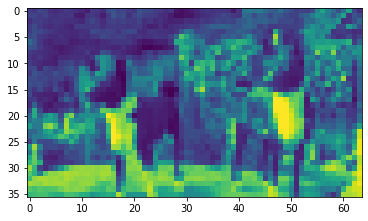

In [49]:
plt.imshow(img/255.0)

---

# Train the model (if you want)
## Build the trainer

In [ ]:
from lurz2020.training.trainers import standard_trainer as trainer

# If you want to allow fine tuning of the core, set detach_core to False
detach_core=False
if detach_core:
    print('Core is fixed and will not be fine-tuned')
else:
    print('Core will be fine-tuned')

trainer_config = {'track_training': True,
                  'detach_core': detach_core}

## Run training (Kandan you need to run this!!!)

In [ ]:
score, output, model_state = trainer(model=model, dataloaders=dataloaders, seed=1, **trainer_config)

## Save the trained model

In [ ]:
torch.save(model.state_dict(), 'models/trained_model.pth.tar') 